# Odhad CDPF

## Cíl analýzy

Cílem analýzy je odhad neoklasické agregátní CDPF.

## Data a metoda

Pro odhad byly použity následující hodnoty:

- hrubá přidaná hodnota (Gross Value Added) (převedená na stálé ceny roku 2010 pomocí deflátoru HDP),
- čistý fixní nefinanční kapitál (převedený na stálé ceny roku 2010 pomocí deflátoru kapitálových zásob),
- celkový počet odpracovaných hodin.

In [20]:
import eurostat
import pandas
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller
from scipy import stats
import statsmodels.tsa.stattools as ts
import numpy
import seaborn

LOCATIONS = ["CZ", "DE", "AT", "EU27_2020", "ES"]
BASE_LOCATION = "CZ"
START_YEAR = 1980
END_YEAR = 2020

### Hrubá přidaná hodnota (Gross Value Added)

Hrubá přidaná hodnota je načtena na základě kódu `nama_10_a10`.

In [21]:
data_1_es = eurostat.get_data_df('nama_10_a10')
data_1 = data_1_es
# Value added, gross
data_1 = data_1[data_1["na_item"] == "B1G"]
# Total, all NACE activities
data_1 = data_1[data_1["nace_r2"] == "TOTAL"]
# Current prices, million euro
data_1 = data_1[data_1["unit"].isin(["CP_MNAC", "PD10_NAC"])]
data_1 = pandas.melt(data_1, id_vars=["unit", "na_item", "geo\\time"], value_vars=list(range(START_YEAR, END_YEAR + 1)),
                     value_name="value", var_name="year")
data_1 = data_1.pivot(index=["na_item", "geo\\time", "year"], columns="unit", values="value")
data_1 = data_1.reset_index()
data_1 = data_1.rename({"CP_MNAC": "gross_value_added", "PD10_NAC": "gross_value_added_deflator"}, axis=1)
data_1["gross_value_added"] = data_1["gross_value_added"] * data_1["gross_value_added_deflator"]
data_1 = data_1.dropna()
data_1.tail()

unit,na_item,geo\time,year,gross_value_added,gross_value_added_deflator
1840,B1G,XK,2016,547200.4080,112.890
1841,B1G,XK,2017,577304.7840,113.064
1842,B1G,XK,2018,617278.2520,114.740
1843,B1G,XK,2019,661185.7636,116.026
1844,B1G,XK,2020,660210.0975,118.095


Pro data provedeme logaritmizaci a určíme hodnoty diferencí.

In [22]:
data_1 = data_1.sort_values(["geo\\time", "year"])
data_1["ln_gross_value_added"] = numpy.log(data_1["gross_value_added"])
data_1["ln_gross_value_added_t_minus_1"] = data_1.groupby("geo\\time")["ln_gross_value_added"].shift(1)
data_1["ln_gross_value_added_diff"] = (data_1["ln_gross_value_added"] - data_1["ln_gross_value_added_t_minus_1"]) / data_1["ln_gross_value_added"]
data_1 = data_1[["geo\\time", "year", "ln_gross_value_added", "ln_gross_value_added_diff"]]
data_1.tail()

unit,geo\time,year,ln_gross_value_added,ln_gross_value_added_diff
1840,XK,2016,13.212570,0.004012
1841,XK,2017,13.266126,0.004037
1842,XK,2018,13.333075,0.005021
1843,XK,2019,13.401790,0.005127
1844,XK,2020,13.400313,-0.000110


Dále načteme informace o odpracovaných hodinách, které mají kód `nama_10_a10_e`.

In [23]:
data_2_es = eurostat.get_data_df('nama_10_a10_e')
data_2 = data_2_es
# Total employment domestic concept
data_2 = data_2[data_2["na_item"] == "EMP_DC"]
# Total, all NACE activities
data_2 = data_2[data_2["nace_r2"] == "TOTAL"]
# Thousands hours worked
data_2 = data_2[data_2["unit"] == "THS_HW"]
data_2 = pandas.melt(data_2, id_vars=["unit", "na_item", "geo\\time"], value_vars=list(range(START_YEAR, END_YEAR + 1)),
                    value_name="thousands_hours_worked", var_name="year")
data_2 = data_2.sort_values(["geo\\time", "year"])
data_2 = data_2.dropna()
data_2["ln_thousands_hours_worked"] = numpy.log(data_2["thousands_hours_worked"])
data_2["ln_thousands_hours_worked_t_minus_1"] = data_2.groupby("geo\\time")["ln_thousands_hours_worked"].shift(1)
data_2["ln_thousands_hours_worked_diff"] = (data_2["ln_thousands_hours_worked"] - data_2["ln_thousands_hours_worked_t_minus_1"]) / data_2["ln_thousands_hours_worked"]
data_2 = data_2[["geo\\time", "year", "ln_thousands_hours_worked", "ln_thousands_hours_worked_diff"]]
data_2.head()

,geo\time,year,ln_thousands_hours_worked,ln_thousands_hours_worked_diff
585,AT,1995,15.666346,NaN
624,AT,1996,15.688559,0.001416
663,AT,1997,15.700493,0.000760
702,AT,1998,15.698566,-0.000123
741,AT,1999,15.715818,0.001098


Jako předposlední krok je načten čistý fixní nefinanční kapitál, který má kód `nama_10_nfa_bs`.

In [24]:
data_3_es = eurostat.get_data_df('nama_10_nfa_bs')

data_3 = data_3_es
data_3 = eurostat.get_data_df('nama_10_nfa_bs')
# Total fixed assets (net)
data_3 = data_3[data_3["asset10"] == "N11N"]
# Total, all activities
data_3 = data_3[data_3["sector"] == "S1"]
# Current fixed prices, millions of national currency
data_3 = data_3[data_3["unit"] == "CP_MNAC"]
data_3 = pandas.melt(data_3, id_vars=["unit", "asset10", "geo\\time"], value_vars=list(range(START_YEAR, END_YEAR + 1)),
                    value_name="total_fixed_assets", var_name="year")
data_3 = data_3.sort_values(["geo\\time", "year"])
data_3 = data_3.dropna()

V posledním kroku je načten deflátor kapitálových zásob, který má kód `nama_10_nfa_fl`.

In [25]:
data_4_es = eurostat.get_data_df('nama_10_nfa_fl')

data_4 = data_4_es
data_4 = data_4[data_4["asset10"] == "N11G"]
data_4 = data_4[data_4["nace_r2"] == "TOTAL"]
data_4 = data_4[data_4["unit"] == "PD10_NAC"]
data_4 = pandas.melt(data_4, id_vars=["unit", "asset10", "geo\\time"], value_vars=list(range(START_YEAR, END_YEAR + 1)),
                    value_name="capital_stock_deflator", var_name="year")
data_4 = data_4.sort_values(["geo\\time", "year"])
data_4 = data_4.dropna()

Hodnota kapitálu je nyní převedena na stálé ceny roku 2010.

In [26]:
data_3 = data_3.merge(data_4, on=["geo\\time", "year"])
data_3["total_fixed_assets"] = data_3["total_fixed_assets"] * data_3["capital_stock_deflator"]
data_3["ln_total_fixed_assets"] = numpy.log(data_3["total_fixed_assets"])
data_3["ln_total_fixed_assets_t_minus_1"] = data_3.groupby("geo\\time")["ln_total_fixed_assets"].shift(1)
data_3["ln_total_fixed_assets_diff"] = (data_3["ln_total_fixed_assets"] - data_3["ln_total_fixed_assets_t_minus_1"]) / data_3["ln_total_fixed_assets"]
data_3 = data_3[["geo\\time", "year", "ln_total_fixed_assets", "ln_total_fixed_assets_diff"]]

In [27]:
data = pandas.merge(data_1, data_2, on=["geo\\time", "year"])
data = pandas.merge(data, data_3, on=["geo\\time", "year"])
data.head()

,geo\time,year,ln_gross_value_added,ln_gross_value_added_diff,ln_thousands_hours_worked,ln_thousands_hours_worked_diff,ln_total_fixed_assets,ln_total_fixed_assets_diff
0,AT,1995,16.381579,NaN,15.666346,NaN,17.736362,NaN
1,AT,1996,16.417358,0.002179,15.688559,0.001416,17.789630,0.002994
2,AT,1997,16.455536,0.002320,15.700493,0.000760,17.841370,0.002900
3,AT,1998,16.498469,0.002602,15.698566,-0.000123,17.884289,0.002400
4,AT,1999,16.535190,0.002221,15.715818,0.001098,17.926085,0.002332


C:\Users\jirip\repos\deotn\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


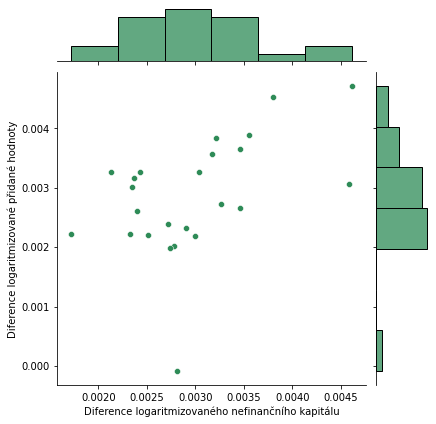

In [28]:
data_plot = data[data["geo\\time"] == "AT"]
h = seaborn.jointplot("ln_total_fixed_assets_diff", "ln_gross_value_added_diff", data_plot, kind='scatter', color='seagreen')
h.set_axis_labels('Diference logaritmizovaného nefinančního kapitálu', 'Diference logaritmizované přidané hodnoty')

Níže je graf vztahu mezi diferencí logaritmovaných odpracovaných hodin a diferencí logaritmované
hrubé přidané hodnoty.
Zde je korelace očividně výrazně slabší.

C:\Users\jirip\repos\deotn\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


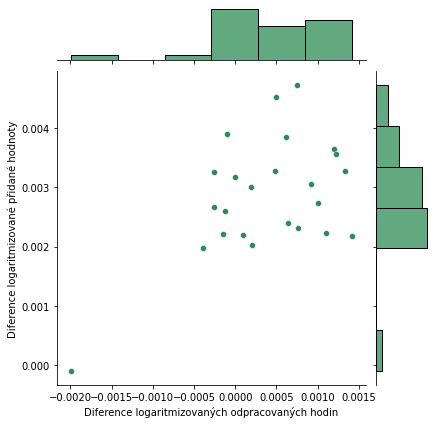

In [29]:
data_plot = data[data["geo\\time"] == "AT"]
h = seaborn.jointplot("ln_thousands_hours_worked_diff", "ln_gross_value_added_diff", data_plot, kind='scatter', color='seagreen')
h.set_axis_labels('Diference logaritmizovaných odpracovaných hodin', 'Diference logaritmizované přidané hodnoty')

In [30]:
data_plot_corr = data_plot.rename(columns={"ln_total_fixed_assets_diff": "Diff. log. nefinančního kapitálu", "ln_gross_value_added_diff": "Diff. log. hrubé přidané hodnoty", "ln_thousands_hours_worked_diff": "Diff. log. odpracovaných hodin"})
data_plot_corr[["Diff. log. nefinančního kapitálu","Diff. log. hrubé přidané hodnoty", "Diff. log. odpracovaných hodin"]].corr()

,Diff. log. nefinančního kapitálu,Diff. log. hrubé přidané hodnoty,Diff. log. odpracovaných hodin
Diff. log. nefinančního kapitálu,1.000000,0.485871,0.270835
Diff. log. hrubé přidané hodnoty,0.485871,1.000000,0.524597
Diff. log. odpracovaných hodin,0.270835,0.524597,1.000000


In [31]:
from statsmodels.tsa.stattools import adfuller
data_plot = data_plot.dropna()
result = adfuller(data_plot["ln_thousands_hours_worked_diff"])
f"p-hodnota testu stacionarity je {result[1]}"

'p-hodnota testu stacionarity je 7.622124526237374e-05'

In [32]:
result = adfuller(data_plot["ln_gross_value_added_diff"])
f"p-hodnota testu stacionarity je {result[1]}"

'p-hodnota testu stacionarity je 0.00035972106440011536'

In [33]:
result = adfuller(data_plot["ln_total_fixed_assets_diff"])
f"p-hodnota testu stacionarity je {result[1]}"

'p-hodnota testu stacionarity je 0.0375822200428525'

In [34]:
result=ts.coint(data_plot["ln_gross_value_added_diff"], data_plot["ln_thousands_hours_worked_diff"])
f"p-hodnota testu kointegrace je {result[1]}"

'p-hodnota testu kointegrace je 0.028624015571291513'

In [35]:
result = ts.coint(data_plot["ln_gross_value_added_diff"], data_plot["ln_total_fixed_assets_diff"])
f"p-hodnota testu kointegrace je {result[1]}"

'p-hodnota testu kointegrace je 0.010143977655327138'

In [36]:
data_plot = data[data["geo\\time"] == "AT"]

data_plot = data_plot[data_plot["year"] > 1996]

mod = smf.ols(formula="ln_gross_value_added_diff ~ ln_thousands_hours_worked_diff + ln_total_fixed_assets_diff", data=data_plot)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     ln_gross_value_added_diff   R-squared:                       0.473
Model:                                   OLS   Adj. R-squared:                  0.421
Method:                        Least Squares   F-statistic:                     8.987
Date:                       Sun, 12 Dec 2021   Prob (F-statistic):            0.00164
Time:                               18:52:34   Log-Likelihood:                 134.14
No. Observations:                         23   AIC:                            -262.3
Df Residuals:                             20   BIC:                            -258.9
Df Model:                                  2                                         
Covariance Type:                   nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          0.0012      0.001      1.740      0.097      -0.000       0.003
ln_thousands_hours_worked_diff     0.6789      0.229      2.963      0.008       0.201       1.157
ln_total_fixed_assets_diff         0.4869      0.234      2.077      0.051      -0.002       0.976
==============================================================================
Omnibus:                        1.949   Durbin-Watson:                   1.245
Prob(Omnibus):                  0.377   Jarque-Bera (JB):                1.051
Skew:                          -0.004   Prob(JB):                        0.591
Kurtosis:                       1.953   Cond. No.                     1.65e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.65e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [38]:
data_plot = data[data["geo\\time"] == "AT"]

data_plot = data_plot[data_plot["year"] > 1996]
data_plot["const"] = 1

import statsmodels.api as sm
mod = sm.RLM(data_plot["ln_gross_value_added_diff"], data_plot[["const", "ln_thousands_hours_worked_diff", "ln_total_fixed_assets_diff"]])
res = mod.fit()
res.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                        Robust linear Model Regression Results                       
=====================================================================================
Dep. Variable:     ln_gross_value_added_diff   No. Observations:                   23
Model:                                   RLM   Df Residuals:                       20
Method:                                 IRLS   Df Model:                            2
Norm:                                 HuberT                                         
Scale Est.:                              mad                                         
Cov Type:                                 H1                                         
Date:                       Sun, 12 Dec 2021                                         
Time:                               18:52:54                                         
No. Iterations:                           35                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                              0.0012      0.001      1.666      0.096      -0.000       0.003
ln_thousands_hours_worked_diff     0.6634      0.239      2.776      0.006       0.195       1.132
ln_total_fixed_assets_diff         0.4903      0.244      2.006      0.045       0.011       0.969
==================================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""